In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels import regression
import matplotlib.pyplot as plt

In [2]:
#forrás: https://www.bet.hu/oldalak/adatletoltes
otp = pd.read_csv('data\otp_2016_01_01__2021_02_11.csv')
zwack=pd.read_csv('data\zwack_2016_01_01__2021_02_11.csv')
bux=pd.read_csv('data\BUX_historikus_2016_01_01__2021_02_11_.csv')
bux.head()

,Név,Dátum,Nyitó ár,Maximum ár,Minimum ár,Utolsó ár
0,BUX,2016.01.04.,23920.455062,23920.455062,23509.118191,23632.571544
1,BUX,2016.01.05.,23632.571544,23861.387786,23632.571544,23861.387786
2,BUX,2016.01.06.,23787.452447,24000.535907,23632.380895,24000.535907
3,BUX,2016.01.07.,24000.129335,24000.535907,23467.548329,23595.103473
4,BUX,2016.01.08.,23595.103473,24027.320338,23595.103473,23956.194258


In [3]:
prices = pd.DataFrame()
prices['otp'] = otp['Utolsó ár']
prices['zwack']=zwack['Utolsó ár']
prices['bux']=bux['Utolsó ár']

In [4]:
cov_matrix = prices.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

,otp,zwack,bux
otp,0.000329,0.000018,0.000187
zwack,0.000018,0.000042,0.000013
bux,0.000187,0.000013,0.000146


In [5]:
e_r = prices.pct_change().mean()
e_r

otp      0.000800
zwack   -0.000024
bux      0.000555
dtype: float64

In [6]:
sd = prices.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
sd

otp      0.286740
zwack    0.102295
bux      0.190926
dtype: float64

In [7]:
assets = pd.concat([e_r, sd], axis=1)
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
otp,0.000800,0.286740
zwack,-0.000024,0.102295
bux,0.000555,0.190926


In [8]:
p_ret = []
p_vol = []
p_weights = []

num_assets = len(prices.columns)
num_portfolios = 1000

In [9]:
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, e_r)
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    sd = np.sqrt(var)
    ann_sd = sd*np.sqrt(250)
    p_vol.append(ann_sd)

In [10]:
data = {'Returns':p_ret, 'Volatility':p_vol}

In [11]:
for counter, symbol in enumerate(prices.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [12]:
portfolios = pd.DataFrame(data)
portfolios.head()

,Returns,Volatility,otp weight,zwack weight,bux weight
0,0.000441,0.159838,0.268481,0.310863,0.420656
1,0.000358,0.138054,0.195910,0.423928,0.380162
2,0.000214,0.106652,0.001251,0.588620,0.410129
3,0.000376,0.144349,0.265859,0.422273,0.311868
4,0.000349,0.139508,0.286131,0.476640,0.237229


<AxesSubplot:xlabel='Volatility', ylabel='Returns'>

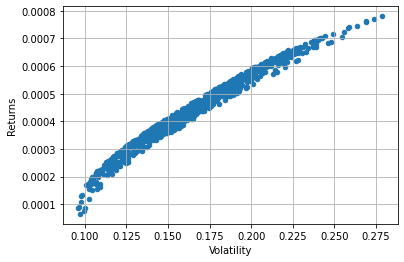

In [13]:
portfolios.plot.scatter(x='Volatility', y='Returns', grid=True)

# Global Minimum Variance Portfolio

In [14]:
portfolios[portfolios['Volatility']==portfolios['Volatility'].min()]

,Returns,Volatility,otp weight,zwack weight,bux weight
160,0.000087,0.095874,0.002056,0.808348,0.189597


In [15]:
min_var_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
min_var_port

Returns         0.000087
Volatility      0.095874
otp weight      0.002056
zwack weight    0.808348
bux weight      0.189597
Name: 160, dtype: float64

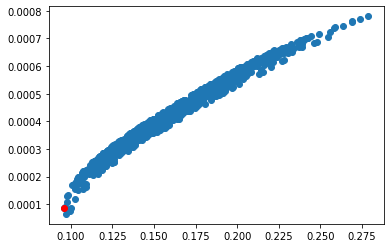

In [33]:
import matplotlib.pyplot as plt
plt.subplots()
plt.scatter(portfolios['Volatility'], portfolios['Returns'])
plt.scatter(min_var_port[1], min_var_port[0], color='r')

# Optimal Risky Portfolio

$$Sharpe Ratio = \frac{E(R_i)-rf}{\sigma_i}$$

In [17]:
rf = 0.005

In [18]:
((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()

405

In [19]:
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Returns         0.000780
Volatility      0.278945
otp weight      0.955069
zwack weight    0.015341
bux weight      0.029590
Name: 405, dtype: float64

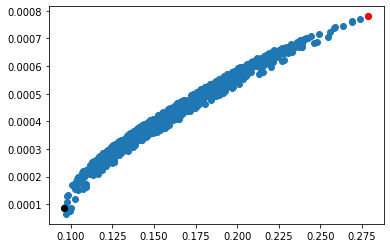

In [20]:
plt.subplots()
plt.scatter(portfolios['Volatility'], portfolios['Returns'])
plt.scatter(min_var_port[1], min_var_port[0], color='k')
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='r')

# Utility Function

$$U = E(R)-0.5A\sigma^2$$

# Capital Allocation Line

$$E(R_P) = rf + \frac{E(R_i)-rf}{\sigma_i}\sigma_p$$

In [29]:
cal_x = []
cal_y = []
utility = []
a = 1

In [30]:
for er in np.linspace(rf, max(p_ret), 20):
    sd = (er - rf)/((optimal_risky_port[0]-rf)/optimal_risky_port[1])
    u = er - .5*a*(sd**2)
    cal_x.append(sd)
    cal_y.append(er)
    utility.append(u)

In [31]:
data2 = {'utility':utility, 'cal_y':cal_y, 'cal_x':cal_x}
cal = pd.DataFrame(data2)
cal.head()

,utility,cal_y,cal_x
0,0.005000,0.005000,-0.000000
1,0.004670,0.004778,0.014681
2,0.004125,0.004556,0.029363
3,0.003364,0.004334,0.044044
4,0.002387,0.004112,0.058725


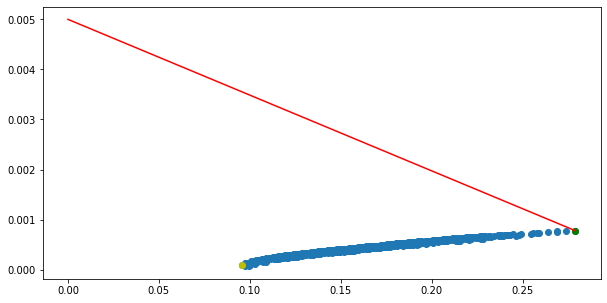

In [32]:
plt.subplots(figsize=(10,5))
plt.scatter(portfolios['Volatility'], portfolios['Returns'])
plt.scatter(min_var_port[1], min_var_port[0], color='y')
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g')
plt.plot(cal_x, cal_y, color='r')

# Investor's Optimal Portfolio

In [25]:
cal['utility'].idxmax()

0

In [26]:
investors_port = cal.iloc[cal['utility'].idxmax()]
investors_port

utility    0.005
cal_y      0.005
cal_x     -0.000
Name: 0, dtype: float64

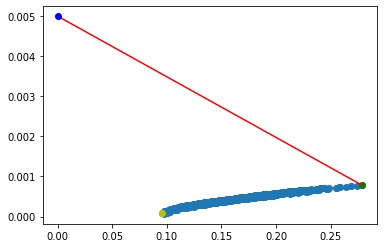

In [28]:
plt.subplots()
plt.scatter(portfolios['Volatility'], portfolios['Returns'])
plt.scatter(min_var_port[1], min_var_port[0], color='y')
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g')
plt.plot(cal_x, cal_y, color='r')
plt.plot(investors_port[2], investors_port[1], 'o', color='b')